In [1]:
## Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [2]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID_1 = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'
MODEL_ID_2 = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_32_firstc_6'

In [4]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())

diffuser_1 = Diffuser(placeholder_dm)
diffuser_1.load(config=config_from_id(MODEL_ID_1), also_ckpt=True, for_training=True)

diffuser_2 = Diffuser(placeholder_dm)
diffuser_2.load(config=config_from_id(MODEL_ID_2), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.
No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [5]:
theta_mean = diffuser_1.diffmodel.ps.sample_theta(10000).mean(dim=0, keepdim=True).to(device)
theta_mean

tensor([[7.0101e+01, 3.2084e-02]], device='cuda:0')

In [6]:
sample = diffuser_1.test_dataloader.dataset[0].unsqueeze(0).unsqueeze(1).to(device)
sample.shape

torch.Size([1, 1, 256, 256])

In [7]:
gen1 = diffuser_1.diffmodel.forward_ode_sampling(sample, thetas= theta_mean)

100%|██████████| 1000/1000 [00:06<00:00, 151.84it/s]


In [8]:
gen2 = diffuser_2.diffmodel.forward_ode_sampling(sample, thetas= theta_mean)

100%|██████████| 1000/1000 [00:04<00:00, 204.05it/s]


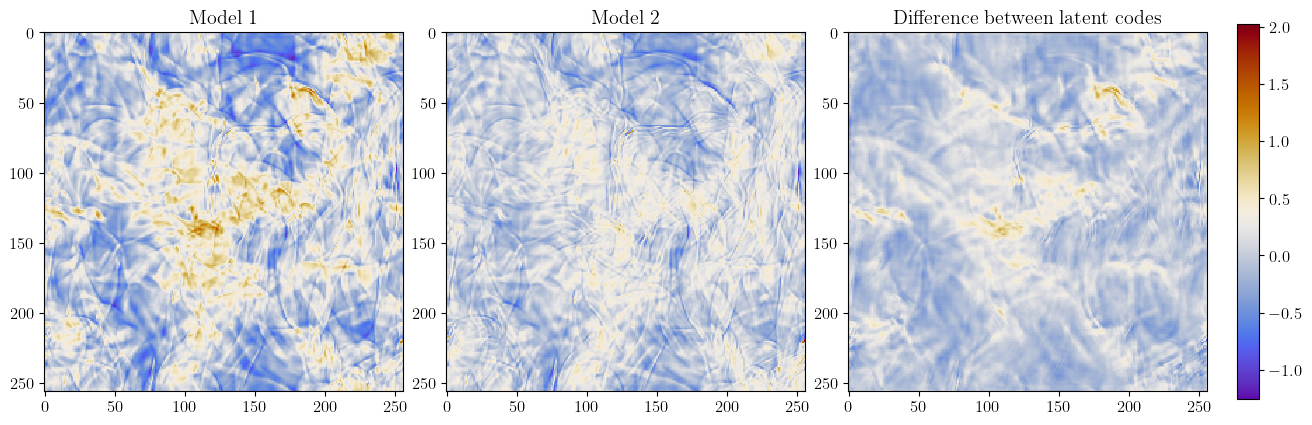

In [17]:
latent_code_1 = gen1[0,0].detach().cpu().numpy()
latent_code_2 = gen2[0,0].detach().cpu().numpy()

vmin = min(latent_code_1.min(), latent_code_2.min())
vmax = max(latent_code_1.max(), latent_code_2.max())

fig, ax = plt.subplots(1,3, figsize=(15,5))
im_1 = ax[0].imshow(latent_code_1, cmap = 'cmb', vmin=vmin, vmax=vmax)
ax[0].set_title('Model 1')
im_2 = ax[1].imshow(latent_code_2, cmap = 'cmb', vmin=vmin, vmax=vmax)
ax[1].set_title('Model 2')
im_3 = ax[2].imshow(latent_code_1 - latent_code_2, cmap = 'cmb', vmin=vmin, vmax=vmax)
ax[2].set_title('Difference between latent codes')
fig.colorbar(im_1, cax=fig.add_axes([0.92, 0.12, 0.015, 0.75])) # left, bottom, width, height
plt.subplots_adjust(wspace=0.12, hspace=0.05)
if save_fig:
    fig.savefig('figs/latent_codes.pdf', bbox_inches='tight')